## Read aberrations - Run tableau

#### Contributor(s): Utkarsh Pratiush <utkarshp1161@gmail.com> - 6th May 2025
#### edited - 
   

We are using the jupyter kernel of python 3.10 for Autoscript compatibility



In [14]:
%matplotlib widget
import matplotlib.pylab as plt
import numpy  as np

import sys
sys.path.insert(0, "..//..//..//..//..//Autoscript//")
from autoscript_tem_microscope_client import TemMicroscopeClient
from autoscript_tem_microscope_client.enumerations import *
from autoscript_tem_microscope_client.structures import *
from autoscript_tem_microscope_client.structures import RunOptiStemSettings

sys.path.insert(0, "..//..//")
from stemOrchestrator.acquisition import CEOSAcquisitionTCP



## Connection for our microscope

We connect to 
- Autoscript
- CEOS SCORR server

In [2]:
ip = "10.46.217.241" 
port_ceos = 7072
port_TF = 9095

microscope = TemMicroscopeClient()
microscope.connect(ip, port=port_TF)
print("Connected to the microscope")

ceos_acquisition = CEOSAcquisitionTCP(host=ip, port=port_ceos)
print("Connected to CEOS SCORR on ", ceos_acquisition.host)

Client connecting to [10.46.217.241:9095]...
Client connected to [10.46.217.241:9095]
Connected to the microscope
Connected to CEOS SCORR on  10.46.217.241


## Check Vacuum

In [102]:
print("microscope vacumm is:",microscope.vacuum.state)
print("column valve is: ", microscope.vacuum.column_valves.state)

microscope vacumm is: Ready
column valve is:  Opened


### Open column valve
If everything is okay we can open the column valve

In [107]:
microscope.vacuum.column_valves.open()

In [124]:
dir(microscope.optics),  microscope.optics.defocus

(['_Optics__acceleration_voltage',
  '_Optics__aperture_mechanisms',
  '_Optics__application_client',
  '_Optics__camera_length',
  '_Optics__deflectors',
  '_Optics__deflectors_raw',
  '_Optics__energy_filter',
  '_Optics__id',
  '_Optics__lenses',
  '_Optics__magnification',
  '_Optics__monochromator',
  '_Optics__stigmators',
  '_Optics__stigmators_raw',
  '__class__',
  '__delattr__',
  '__dir__',
  '__doc__',
  '__eq__',
  '__format__',
  '__ge__',
  '__getattribute__',
  '__gt__',
  '__hash__',
  '__init__',
  '__init_subclass__',
  '__le__',
  '__lt__',
  '__module__',
  '__ne__',
  '__new__',
  '__reduce__',
  '__reduce_ex__',
  '__repr__',
  '__setattr__',
  '__sizeof__',
  '__slots__',
  '__str__',
  '__subclasshook__',
  'acceleration_voltage',
  'aperture_mechanisms',
  'beam_diameter',
  'blank',
  'camera_length',
  'convergence_angle',
  'deflectors',
  'deflectors_raw',
  'defocus',
  'energy_filter',
  'focus',
  'illumination_mode',
  'intensity',
  'is_accelerator_on

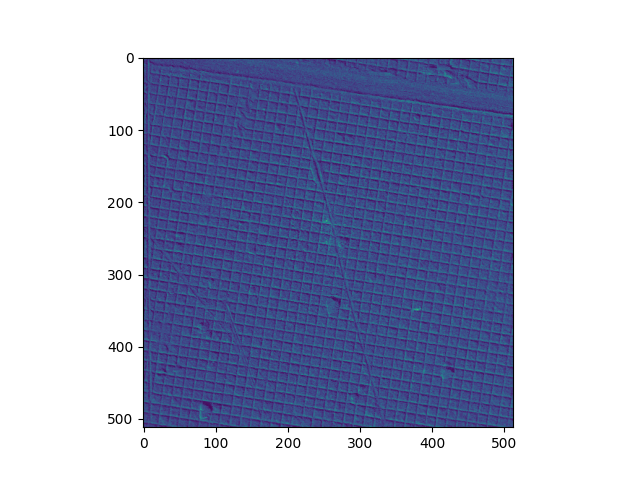

In [110]:
microscope.optics.defocus = 0e-9
microscope.optics.scan_field_of_view  = 17*1e-6
haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 4e-6)# haadf is pixel wise
fig = plt.figure()
im =  plt.imshow(haadf_image.data)

use 
- tabtype can be "Fast", "Standard", "Enhanced"
- angle is in mili-radian
- We want the first orders from this defocus=C1=C$_{1,0}$, astigmatismus A1,B2, A2

In [125]:
dir(microscope.optics.monochromator)

['_Monochromator__application_client',
 '_Monochromator__id',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 'focus',
 'shift']

In [11]:
microscope.optics.unblank()


In [16]:

tableau_result = ceos_acquisition.run_tableau(tab_type="Fast", angle=1)
tableau_result['aberrations']

{'A1': [7.233881899815679e-11, -6.812939270239466e-10],
 'A2': [-4.300087156199279e-08, -6.644510829063206e-09],
 'B2': [5.184540491702422e-09, -8.61161576046274e-09],
 'C1': [-4.869789706839253e-09, 0.0],
 'WD': [0.00043683732577047194, 0.0007427092603041539]}

In [9]:
ceos_acquisition.correct_aberration("C1", value=tableau_result['aberrations']['C1'])

In [17]:
def correct_low_orders(aberrations):
    ceos_acquisition.correct_aberration("C1", value=aberrations['C1'])
    ceos_acquisition.correct_aberration("A1", value=aberrations['A1'])
    if np.linalg.norm(aberrations['A2'][0]) >50e-9:
        ceos_acquisition.correct_aberration("A2", value=aberrations['A2'])
    if np.linalg.norm(aberrations['B2'][0]) >50e-9:
        ceos_acquisition.correct_aberration("B2", value=aberrations['B2'])

correct_low_orders(tableau_result['aberrations'])

In [57]:
microscope.optics.scan_field_of_view  = 372*1e-9
microscope.optics.unblank()

tableau_result3 = ceos_acquisition.run_tableau(tab_type="Fast", angle=2)# use "Fast", "Standard", "Enhanced" --angle is in mili-radian 9,18,343

tableau_result3


{'aberrations': {'A1': [-7.901964772825174e-10, 1.3179868703508654e-09],
  'A2': [-3.120937558526664e-08, -8.701740983782275e-09],
  'B2': [1.7885141288291806e-08, -4.843287418491422e-08],
  'C1': [1.1917011757236098e-08, 0.0],
  'WD': [-3.331808592722305e-05, -0.00013774932750723693]},
 'confidence': {'A1': 1.4081854011373633e-09,
  'A2': 4.6585916040518566e-08,
  'B2': 4.590204893821498e-08,
  'C1': 7.040927005686817e-10,
  'WD': nan}}

In [58]:

microscope.optics.scan_field_of_view  = 372*1e-9
microscope.optics.unblank()


tableau_result = ceos_acquisition.run_tableau(tab_type="Enhanced", angle=40)# use "Fast", "Standard", "Enhanced" --angle is in mili-radian 9,18,343

tableau_result


{'aberrations': {'A1': [-8.878116792054956e-10, 1.8275285296416946e-09],
  'A2': [8.174011287966841e-08, 6.593045537258123e-09],
  'C3': [1.9511946474391283e-07, 0.0],
  'C1': [1.0101620597744015e-08, 0.0],
  'A4': [-1.546950062881775e-06, -1.3407742581409087e-06],
  'A3': [6.037940279539519e-08, -4.366481366728181e-09],
  'A5': [2.6090829841073607e-05, -5.881522887277552e-05],
  'B2': [6.275015215733142e-08, -4.4570267393417804e-08],
  'B4': [-2.501179301112737e-06, 1.5371450229614058e-06],
  'S3': [2.5124288636072836e-07, 1.8346257965023732e-07],
  'C5': [-0.000194881543174418, 0.0],
  'D4': [2.2493692332427856e-06, 5.322314237729821e-07],
  'WD': [0.00019100003935697363, -9.681421232052702e-06]},
 'confidence': {'A1': 2.229425317178956e-09,
  'A2': 4.260296234806818e-08,
  'C3': 1.2674369828027857e-06,
  'C1': 1.5181041612146323e-09,
  'A4': 6.279212873259078e-06,
  'A3': 3.7840278405989686e-07,
  'A5': 0.00010988950915883996,
  'B2': 3.257664915653425e-08,
  'B4': 7.086127910206621

In [131]:
%load_ext autoreload
%autoreload 2
sys.path.insert(0, "..//..//..//..//..//pyTEMlib//")
import pyTEMlib
import pyTEMlib.probe_tools
pyTEMlib.__version__

'0.2025.04.0'

In [133]:
aberrations = pyTEMlib.probe_tools.ceos_carth_to_nion(tableau_result['aberrations'])
pyTEMlib.probe_tools.print_aberrations(aberrations)

KeyError: 'C10'

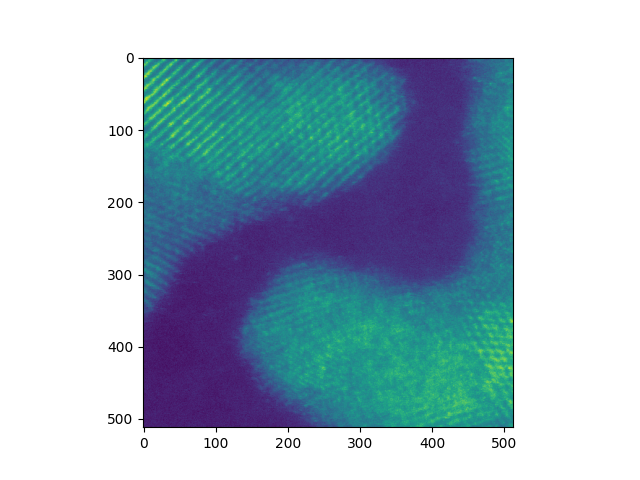

In [61]:
# microscope.optics.defocus = -27e-9
microscope.optics.scan_field_of_view  = 10*1e-9
haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 16e-6)# haadf is pixel wise
fig = plt.figure()
im =  plt.imshow(haadf_image.data)

In [48]:
ceos_acquisition.correct_aberration("C1", value=(2e-9, 0), select="fine")

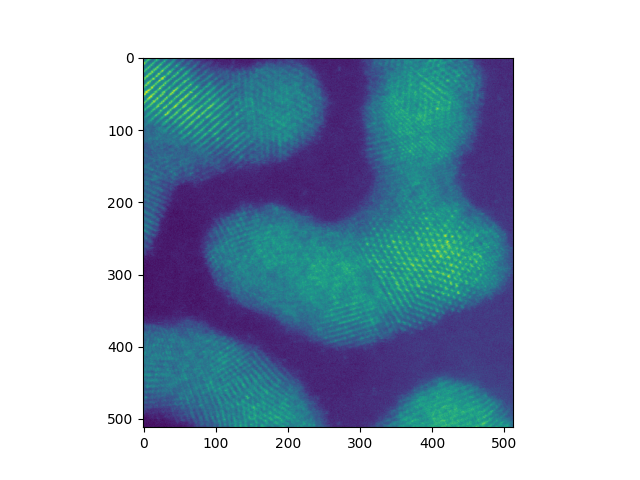

In [54]:
#microscope.optics.defocus = -39e-9
microscope.optics.scan_field_of_view  = 15*1e-9
haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 16e-6)# haadf is pixel wise
fig = plt.figure()
im =  plt.imshow(haadf_image.data)

In [41]:
microscope.optics.scan_field_of_view  = 25*1e-9

settings = RunOptiStemSettings(method=OptiStemMethod.C1_A1, dwell_time=2*1e-6, cutoff_in_pixels=5)
microscope.auto_functions.run_opti_stem(settings)

RunOptiStemResults(quality=Good)

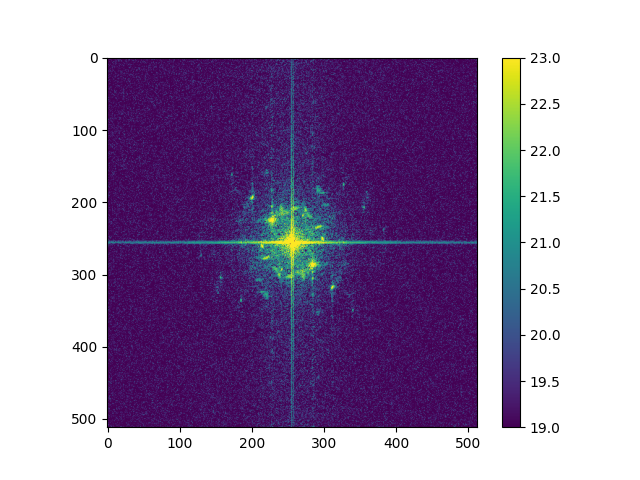

In [62]:
import numpy as np
fft_image = np.fft.fftshift(np.fft.fft2(haadf_image.data))

plt.figure()
plt.imshow(np.log2(1+np.abs(fft_image)), vmin=19, vmax=23)
plt.colorbar()



In [64]:
import sidpy

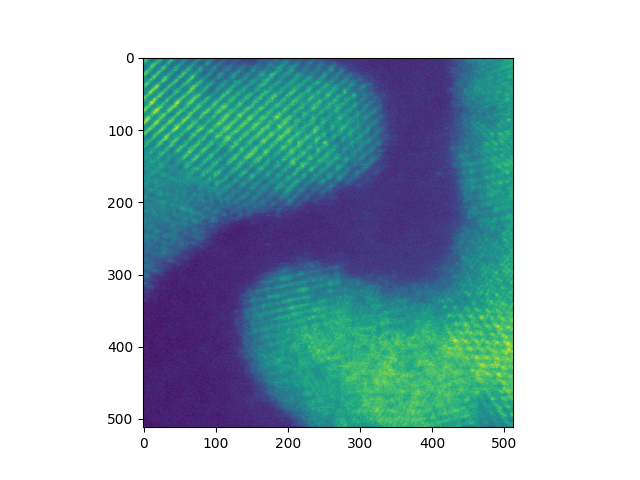

In [70]:
#microscope.optics.defocus = -39e-9
microscope.optics.scan_field_of_view  = 10*1e-9
haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 16e-6)# haadf is pixel wise
fig = plt.figure()
im =  plt.imshow(haadf_image.data)

In [69]:
for i in range(10):
    haadf_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, 512, 4e-6)# haadf is pixel wise
    im.set_data(haadf_image.data)
    #fig.canvas.draw()     

    print(i)

0
1
2
3
4
5
6
7
8
9


In [79]:
dir(haadf_image.metadata)

['_Acquisition',
 '_BinaryResult',
 '_Core',
 '_CustomPropertyGroup',
 '_CustomSectionGroup',
 '_EnergyFilterSettings',
 '_GasInjectionSystems',
 '_Instrument',
 '_Labels',
 '_Optics',
 '_Sample',
 '_ScanSettings',
 '_StageSettings',
 '_StructureBase__repr_format_defaults',
 '_VacuumProperties',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_analytical_detectors',
 '_clear_items',
 '_construct_ineligible_value_error_message',
 '_deserialize',
 '_deserialize_from',
 '_generate_repr',
 '_get_item',
 '_has_item',
 '_has_raw_metadata_as_xml',
 '_imaging_detectors',
 '_init_in_progress',
 '_init_item',
 '_is_value_eligible',
 '_items',
 '_lazy_deserializati

In [98]:
dir(haadf_image.metadata.binary_result), haadf_image.metadata.binary_result.pixel_size_x_unit



(['_AcquisitionArea',
  '_AcquisitionUnit',
  '_BitsPerPixel',
  '_BlackLevel',
  '_CompositionType',
  '_Detector',
  '_DetectorIndex',
  '_DigitalBrightness',
  '_DigitalContrast',
  '_Encoding',
  '_FilterFrameCount',
  '_FilterType',
  '_Gamma',
  '_ImageSize',
  '_IntensityOffset',
  '_IntensityScale',
  '_IntensityScaleUnit',
  '_Offset',
  '_PixelSize',
  '_PixelSizeXUnit',
  '_PixelSizeYUnit',
  '_PixelValueMaximum',
  '_PixelValueMean',
  '_PixelValueMinimum',
  '_PixelValueStandardDeviation',
  '_RecursiveFilterCoefficient',
  '_ReferenceTransformation',
  '_Sharpness',
  '_SharpnessAlgorithm',
  '_Sigma',
  '_WhiteLevel',
  '__class__',
  '__delattr__',
  '__dict__',
  '__dir__',
  '__doc__',
  '__eq__',
  '__format__',
  '__ge__',
  '__getattribute__',
  '__gt__',
  '__hash__',
  '__init__',
  '__init_subclass__',
  '__le__',
  '__lt__',
  '__module__',
  '__ne__',
  '__new__',
  '__reduce__',
  '__reduce_ex__',
  '__repr__',
  '__setattr__',
  '__sizeof__',
  '__str__',
  

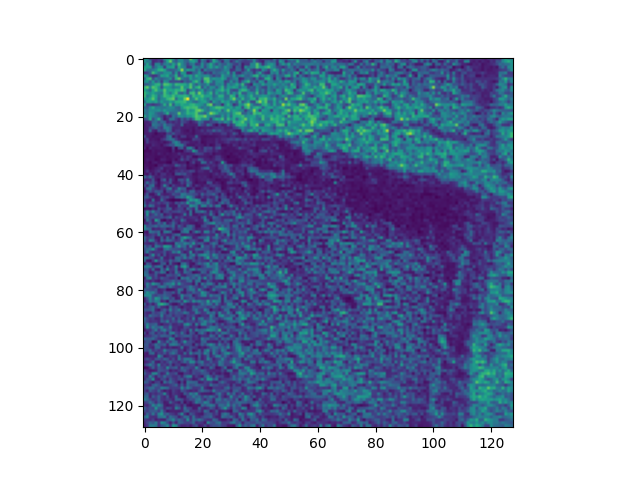

In [21]:
%matplotlib widget
import matplotlib.pylab as plt

fig = plt.figure()
im =  plt.imshow(haadf_image.data)